# Simulació parking: descoberta de patrons amb clustering
# Guardar el model /Carregar el model / Predicció de nous valors

In [1]:
import pandas as pd

### Carreguem el dataset

In [2]:
path_to_file = 'data/registre_durada.csv'
parking_data = pd.read_csv(path_to_file, delimiter=';')

### Manipulació de les dades

In [3]:
parking_data = parking_data.drop('dia_hora', axis=1)
parking_data = parking_data.drop('dia_setmana', axis=1)
parking_data = parking_data.drop('tipus', axis=1)
parking_data[:3]

,matricula,durada,hora,dia_setmana_dec
0,9067 SAG,13375,22.3,5.9
1,9067 SAG,10769,19.5,6.8
2,9067 SAG,8207,21.6,5.9


In [4]:
parking_data_gb = parking_data.groupby(['matricula']).mean()
parking_data_gb = parking_data_gb.merge(parking_data.groupby(['matricula']).count()['durada'], how='inner', on='matricula')
parking_data_gb = parking_data_gb.rename(columns={'durada_x': 'durada', 'durada_y': 'count'})
parking_data_gb[:3]

,durada,hora,dia_setmana_dec,count
matricula,,,,
0001 DKR,21442.695652,9.053261,2.150000,92
0007 QNR,11263.631579,10.515789,6.442105,19
0015 CIQ,7610.200000,14.360000,2.110000,10


In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(parking_data_gb)
parking_data_gb_norm = pd.DataFrame(scaler.transform(parking_data_gb), index=parking_data_gb.index, columns=parking_data_gb.columns)

In [6]:
from sklearn.cluster import KMeans

# Selecting durada, hora, dia_setmana_dec, count
selected_data = parking_data_gb_norm.iloc[:, 0:4]

### Entrenament del model

In [7]:
clustering_model = KMeans(n_clusters=4,random_state=42)

clustering_model.fit(selected_data)

/home/joan/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

### Visualització

<Axes: xlabel='hora', ylabel='count'>

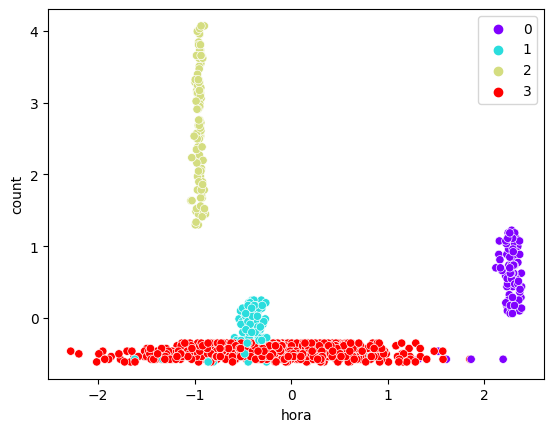

In [8]:
import seaborn as sns

data_labels = clustering_model.labels_
sns.scatterplot(x='hora', 
                y='count', 
                data=selected_data, 
                hue=data_labels,
                palette="rainbow")

### Associació dels labels amb els tipus

In [9]:
tipus = [{'name': 'tipus I'}, {'name': 'tipus II'}, {'name': 'tipus III'}, {'name': 'tipus IV'}]
dicc = {'durada':0, 'hora': 1, 'dia_setmana_dec': 2, 'count': 3}

ind_label_0 = -1
ind_label_1 = -1
ind_label_2 = -1
ind_label_3 = -1

val_hora_max = -1
val_count_max = -1
val_durada_max = -1
val_count_min = 1000

for i, center in enumerate(clustering_model.cluster_centers_):
    
    v_hora = round(center[dicc['hora']],1)
    v_durada = round(center[dicc['durada']],1)
    v_count = round(center[dicc['count']],1)
    
    if (v_hora) > val_hora_max:
        ind_label_0 = i
        val_hora_max = v_hora
    if (v_count) > val_count_max:
        ind_label_2 = i
        val_count_max = v_count
    if (v_count) < val_count_min:
        ind_label_3 = i
        val_count_min = v_count
    if (v_hora < 0 and v_durada > 0 and v_count < 0):
        ind_label_1 = i

tipus[0].update({'label': ind_label_0})
tipus[1].update({'label': ind_label_1})
tipus[2].update({'label': ind_label_2})
tipus[3].update({'label': ind_label_3})

print(tipus)

[{'name': 'tipus I', 'label': 0}, {'name': 'tipus II', 'label': 1}, {'name': 'tipus III', 'label': 2}, {'name': 'tipus IV', 'label': 3}]


### Guardem els models

In [10]:
import pickle

with open('model/scaler.pkl','wb') as f:
    pickle.dump(scaler, f)
    
with open("model/clustering_model.pkl", "wb") as f:
    pickle.dump(clustering_model, f)

with open("model/tipus_dict.pkl", "wb") as f:
    pickle.dump(tipus, f)

## Predicció de nous valors

### Carreguem els models

In [11]:
with open("model/clustering_model.pkl", "rb") as f:
    clustering_model_loaded = pickle.load(f)
    
with open('model/scaler.pkl','rb') as f:
    scaler_loaded = pickle.load(f)
    
with open('model/tipus_dict.pkl','rb') as f:
    tipus_loaded = pickle.load(f)

### Un cotxe de cada tipus

In [12]:
dades_cotxe = [
    # tipus I
    ['3560 ROQ', 7197, 21.5, 6 + 21.5/24],
    ['3560 ROQ', 4941, 21.1, 5 + 21.1/24],
    ['3560 ROQ', 13461, 20.1, 6 + 20.1/24],
    ['3560 ROQ', 13818, 19.4, 5 + 19.4/24],
    ['3560 ROQ', 11251, 19.9, 6 + 19.9/24],
    
    # tipus II
    ['6897 JWK', 12195, 12.2, 6 + 12.2/24],
    ['6897 JWK', 11881, 11.2, 6 + 11.2/24],
    ['6897 JWK', 12885, 11.5, 6 + 11.5/24],
    ['6897 JWK', 10549, 11.1, 6 + 11.1/24],
    ['6897 JWK', 2359, 11.6, 6 + 11.6/24],
    
    # tipus III
    ['1200 ABC', 18264, 7.5, 0 + 7.5/24],
    ['1200 ABC', 22436, 7.7, 1 + 7.7/24],
    ['1200 ABC', 19223, 8.2, 2 + 8.2/24],
    ['1200 ABC', 20256, 9.0, 3 + 9.0/24],
    ['1200 ABC', 21345, 7.6, 4 + 7.6/24],
    
    # tipus IV
    ['4030 JQC', 3600, 7.5, 0 + 7.5/24],
    ['4030 JQC', 2000, 21.0, 2 + 21.0/24],
    ['4030 JQC', 4000, 12.4, 4 + 12.4/24],
    ['4030 JQC', 2500, 11.3, 6 + 11.3/24],
    ['4030 JQC', 800, 15.0, 2 + 15.0/24]
]*2
    
df_dades_cotxe = pd.DataFrame(columns=['matricula', 'durada', 'hora', 'dia_setmana_dec'], data=dades_cotxe)

In [13]:
df_dades_cotxe_gb = df_dades_cotxe.groupby(['matricula']).mean()
df_dades_cotxe_gb = df_dades_cotxe_gb.merge(df_dades_cotxe.groupby(['matricula']).count()['durada'], how='inner', on='matricula')
df_dades_cotxe_gb = df_dades_cotxe_gb.rename(columns={'durada_x': 'durada', 'durada_y': 'count'})

In [14]:
df_dades_cotxe_gb_norm = pd.DataFrame(scaler_loaded.transform(df_dades_cotxe_gb), index=df_dades_cotxe_gb.index, columns=df_dades_cotxe_gb.columns)

In [15]:
nova_prediccio = clustering_model_loaded.predict(df_dades_cotxe_gb_norm)
nova_prediccio

array([2, 0, 3, 1], dtype=int32)

In [16]:
for i, pred in enumerate(nova_prediccio):
    print('{}: label {}: {}'.format(df_dades_cotxe_gb_norm.index[i], nova_prediccio[i], tipus_loaded[nova_prediccio[i]]['name']))
    

1200 ABC: label 2: tipus III
3560 ROQ: label 0: tipus I
4030 JQC: label 3: tipus IV
6897 JWK: label 1: tipus II
